In [6]:
    %pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [105]:
class IterativeSolver:
    iterations = 0
    done = False
    converged = False
    def __init__(self, N, name, do_plot=True):
        self.name = name
        self.N = N 
        self.dt = 1.0 /(N - 1.0)
        self.t = numpy.linspace(0.0, 1.0, N)

        numpy.random.seed(42)
        self.x = 0.0 * numpy.random.rand(self.N)
        self.b = 8.0 * self.dt**2 * numpy.ones(self.N)
        self.force_boundaries();

        self.residuals = [numpy.std(self.residual())]

        if do_plot:
            plt.figure("Solution {}".format(self.name), figsize=(16,9))
            plt.plot(self.t, 4.0 * self.t * (1.0 - self.t), 'k--', label="solution", lw=2)
            plt.legend()

    def force_boundaries(self):
        self.x[0] = 0.0
        self.x[-1] = 0.0

    def plot_solution(self, marker="-", label=""):
        plt.figure("Solution {}".format(self.name), figsize=(16,9))
        plt.plot(self.t, self.x, marker, label="{} {} {}".format(self.name, label, self.iterations))
        plt.legend()

    def plot_residuals(self, marker="-"):
        plt.figure("Residuals", figsize=(16,9))
        plt.semilogy(numpy.array(self.residuals) / self.residuals[0], marker, label=self.name)
        plt.legend()

    def residual(self):
        r = self.b - (-numpy.roll(self.x, -1) + 2.0 * self.x - numpy.roll(self.x, +1))
        r[0] = 0.0
        r[-1] = 0.0
        return r
    
    def run_batch(self, n):
        if self.done: return
        
        for j in range(n):
            self.step()
            res = self.residual()
            std = numpy.std(res)
            
            if (len(self.residuals) > self.N) and (self.residuals[-1]/self.residuals[0] < 1.0e-6):
                prev_std = self.residuals[-1]
                log_std = numpy.log10(std)
                log_prev_std = numpy.log10(prev_std)
                if (not self.converged) and (log_std > log_prev_std):
                    self.converged = True
                    self.converged_at = len(self.residuals)
                    print("Converged", len(self.residuals))

            self.residuals.append(std)
            self.iterations += 1
    
            if self.converged and (len(self.residuals) > 1.2 * self.converged_at):
                self.done = True
                print("Done")
                break
        #print("Finished {} iterations".format(self.iterations))
    
    def run_full(self, m=100000000):
        if self.done: return
        
        thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]
        threshold_index = 0
        for i in range(m):
            if (threshold_index < len(thresholds)) and (self.x[self.N//2] >= thresholds[threshold_index]):
                self.plot_solution(label="{:.0f}%".format(100*thresholds[threshold_index]))
                threshold_index += 1;
                
            self.step()
            res = self.residual()
            std = numpy.std(res)
            
            if (len(self.residuals) > self.N) and (self.residuals[-1] / self.residuals[0] < 1.0e-6):
                prev_std = self.residuals[-1]
                log_std = numpy.log10(std)
                log_prev_std = numpy.log10(prev_std)
                if (not self.converged) and (log_std > log_prev_std):
                    self.converged = True
                    self.converged_at = len(self.residuals)
                    print("Converged", len(self.residuals))
        
            self.residuals.append(std)
            self.iterations += 1
                
            if self.converged and (len(self.residuals) > 1.2 * self.converged_at):
                self.done = True
                print("Done")
                break
        self.plot_solution(marker="--", label="done")
        #print("Finished {} iterations".format(self.iterations))


In [101]:
class JacobiSolver(IterativeSolver):
	def step(self):
		self.x = (self.b + (numpy.roll(self.x, -1) + numpy.roll(self.x, +1))) / 2.0
		self.force_boundaries();

class WeightedJacobiSolver(IterativeSolver):
	omega = 2.0 / 3.0
	def step(self):
		self.x = self.x * (1.0 - self.omega) + self.omega * (self.b + (numpy.roll(self.x, -1) + numpy.roll(self.x, +1))) / 2.0
		self.force_boundaries();

class RedBlackGaussSeidelSolver(IterativeSolver):
	def step(self):
		self.x[0::2] = (self.b[0::2] + (numpy.roll(self.x, -1)[0::2] + numpy.roll(self.x, +1)[0::2])) / 2.0
		self.force_boundaries();
		self.x[1::2] = (self.b[1::2] + (numpy.roll(self.x, -1)[1::2] + numpy.roll(self.x, +1)[1::2])) / 2.0	
		self.force_boundaries();

class GaussSeidelSolver(IterativeSolver):
	def step(self):
		for i in range(1, len(self.x)-1):
			self.x[i] = (self.b[i] + (self.x[i-1] + self.x[i+1])) / 2.0

class SuccessiveOverRelaxationSolver(IterativeSolver):
	def __init__(self, N, name, omega):
		self.omega = omega
		IterativeSolver.__init__(self, N, name)

	def step(self):
		for i in range(1, len(self.x)-1):
			self.x[i] = self.x[i] * (1.0 - self.omega) + self.omega * (self.b[i] + (self.x[i-1] + self.x[i+1])) / 2.0

class RedBlackSuccessiveOverRelaxationSolver(IterativeSolver):
	def __init__(self, N, name, omega):
		self.omega = omega
		IterativeSolver.__init__(self, N, name)

	def step(self):
		self.x[0::2] = self.x[0::2] * (1.0 - self.omega) + self.omega * (self.b[0::2] + (numpy.roll(self.x, -1)[0::2] + numpy.roll(self.x, +1)[0::2])) / 2.0
		self.force_boundaries();
		self.x[1::2] = self.x[1::2] * (1.0 - self.omega) + self.omega * (self.b[1::2] + (numpy.roll(self.x, -1)[1::2] + numpy.roll(self.x, +1)[1::2])) / 2.0	
		self.force_boundaries();


class ConjugateGradientSolver(IterativeSolver):
    # https://en.wikipedia.org/wiki/Conjugate_gradient_method#The_resulting_algorithm
    def __init__(self, N, name):
        IterativeSolver.__init__(self, N, name)
        self.r = self.residual()
        self.p = 1.0 * self.r
        self.rr_old = numpy.dot(self.r, self.r)

    def mul(self, x):
        y = (-numpy.roll(x, -1) + 2.0 * x - numpy.roll(x, +1))
        y[0] = 0.0
        y[-1] = 0.0
        return y

    def step(self):
        Ap = self.mul(self.p)
        alpha = self.rr_old / numpy.dot(self.p, Ap)
        self.x = self.x + alpha * self.p
        self.r = self.r - alpha * Ap

        rr_new = numpy.dot(self.r, self.r)
        beta = rr_new / self.rr_old
        self.p = self.r + beta * self.p
        self.rr_old = rr_new

In [102]:
def coarsen(r):
    r = (numpy.roll(r, -1)[::2] + 2 * r[::2] + numpy.roll(r, +1)[::2]) / 4
    r[0] = 0.0
    r[-1] = 0.0
    return r

"""
0 1 2 3 4
0   1   2
"""
def interpolate(e):
    c = numpy.empty(2*(len(e) - 1)+1, dtype=e.dtype)
    #print("from", len(e), "to", len(c))
    c[0::2] = e
    c[1::2] = (e[:-1] + numpy.roll(e[:-1], -1)) / 2.0
    c[0] = 0.0
    c[-1] = 0.0
    return c

class WeightedJacobiMultigridSolver(WeightedJacobiSolver):
    def __init__(self, N, name):
        #print("name: {}, N: {}".format(name, N))
        WeightedJacobiSolver.__init__(self, N, "{} {}".format(name, N), False)
        #self.x = self.b / 2
        self.parent = None
        if N > 3:
            self.coarse = WeightedJacobiMultigridSolver((N-1)//2+1, name)
            self.coarse.parent = self
        else:
            self.coarse = None


    def cycle(self, preCycles, postCycles, solveCycles, freeStep):
        if self.N > 3:
            #print("cylce", len(self.x))
            # pre-smooth
            for i in range(preCycles): self.step()

            # coarsen
            r = self.residual()
            self.coarse.b = coarsen(r) * 4.0
            
            if freeStep: self.coarse.x = 2.0 / 3.0 * self.coarse.b / 2.0
            else:        self.coarse.x = 0.0 * self.coarse.x

            self.coarse.cycle(preCycles, postCycles, solveCycles, freeStep)

            self.x += interpolate(self.coarse.x)

            for i in range(postCycles): self.step()
        else:
            for i in range(solveCycles): self.step()
        
        self.iterations += 1
        self.residuals.append(numpy.std(self.residual()))
        #self.plot_solution()

class GaussSeidelMultigridSolver(GaussSeidelSolver):
    def __init__(self, N, name):
        #print("name: {}, N: {}".format(name, N))
        WeightedJacobiSolver.__init__(self, N, "{} {}".format(name, N), False)
        #self.x = self.b / 2
        self.parent = None
        if N > 3:
            self.coarse = GaussSeidelMultigridSolver((N-1)//2+1, name)
            self.coarse.parent = self
        else:
            self.coarse = None


    def cycle(self, preCycles, postCycles, solveCycles, freeStep):
        if self.N > 3:
            #print("cylce", len(self.x))
            # pre-smooth
            for i in range(preCycles): self.step()

            # coarsen
            r = self.residual()
            self.coarse.b = coarsen(r) * 4.0
            
            if freeStep: self.coarse.x = 2.0 / 3.0 * self.coarse.b / 2.0
            else:        self.coarse.x = 0.0 * self.coarse.x

            self.coarse.cycle(preCycles, postCycles, solveCycles, freeStep)

            self.x += interpolate(self.coarse.x)

            for i in range(postCycles): self.step()
        else:
            for i in range(solveCycles): self.step()
        
        self.iterations += 1
        self.residuals.append(numpy.std(self.residual()))
        #self.plot_solution()

class RedBlackGaussSeidelMultigridSolver(RedBlackGaussSeidelSolver):
    def __init__(self, N, name):
        #print("name: {}, N: {}".format(name, N))
        WeightedJacobiSolver.__init__(self, N, "{} {}".format(name, N), False)
        #self.x = self.b / 2
        self.parent = None
        if N > 3:
            self.coarse = RedBlackGaussSeidelMultigridSolver((N-1)//2+1, name)
            self.coarse.parent = self
        else:
            self.coarse = None


    def cycle(self, preCycles, postCycles, solveCycles, freeStep):
        if self.N > 3:
            # print("cylce", len(self.x))
            # pre-smooth
            for i in range(preCycles): self.step()

            # coarsen
            r = self.residual()
            self.coarse.b = coarsen(r) * 4.0
            
            if freeStep: self.coarse.x = 2.0 / 3.0 * self.coarse.b / 2.0
            else:        self.coarse.x = 0.0 * self.coarse.x

            self.coarse.cycle(preCycles, postCycles, solveCycles, freeStep)

            self.x += interpolate(self.coarse.x)

            for i in range(postCycles): self.step()
        else:
            for i in range(solveCycles): self.step()
        
        self.iterations += 1
        self.residuals.append(numpy.std(self.residual()))
        #self.plot_solution()


In [103]:
def do_jacobi():
	s = JacobiSolver(128, "Jacobi")
	s.run_full()
	s.plot_residuals()

def do_weighted_jacobi():
	s = WeightedJacobiSolver(128, "Weighted Jacobi 2/3")
	s.run_full()
	s.plot_residuals()

def do_gauss_seidel():
	s = GaussSeidelSolver(128, "Gauss-Seidel")
	s.run_full()
	s.plot_residuals()

def do_red_black_gauss_seidel():
	s = RedBlackGaussSeidelSolver(128, "Red-Black Gauss-Seidel")
	s.run_full()
	s.plot_residuals()

def do_successive_over_relaxation(omega):
	s = SuccessiveOverRelaxationSolver(128, "Successive Over-Relaxation {}".format(omega), omega)
	s.run_full()
	s.plot_residuals()

def do_red_black_successive_over_relaxation(omega):
	s = RedBlackSuccessiveOverRelaxationSolver(128, "Red-Black Successive Over-Relaxation {}".format(omega), omega)
	
	s.run_full()

	s.plot_residuals()

def do_conjugate_gradient():
    s = ConjugateGradientSolver(128, "Conjugate Gradient")
    
    s.run_full(2*s.N//2+3)

    s.plot_residuals()

def do_weighted_jacobi_multigrid(mode):
    def foo(preCycles, postCycles, solveCycles, freeStep):
        if mode == 0: s = WeightedJacobiMultigridSolver(129, "Weighted Jacobi Multigrid pre: {} post: {}, N:".format(preCycles, postCycles))
        elif mode == 1: s = GaussSeidelMultigridSolver(129, "Gauss-Seidel Multigrid pre: {} post: {}, N:".format(preCycles, postCycles))
        elif mode == 2: s = RedBlackGaussSeidelMultigridSolver(129, "Red-Black Gauss-Seidel Multigrid pre: {} post: {}, N:".format(preCycles, postCycles))
        for i in range(11): 
            s.cycle(preCycles, postCycles, solveCycles, freeStep)
        s.plot_residuals('o-')

    for pre in range(1, 3):
        for post in range(1, 6):
            for free in [True]:
                foo(pre, post, 10, free)


Converged 76768
Done


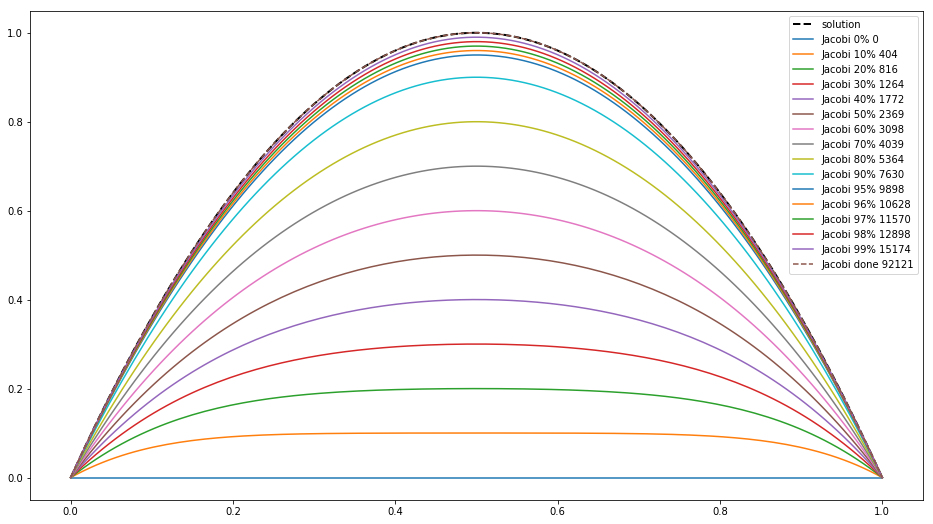

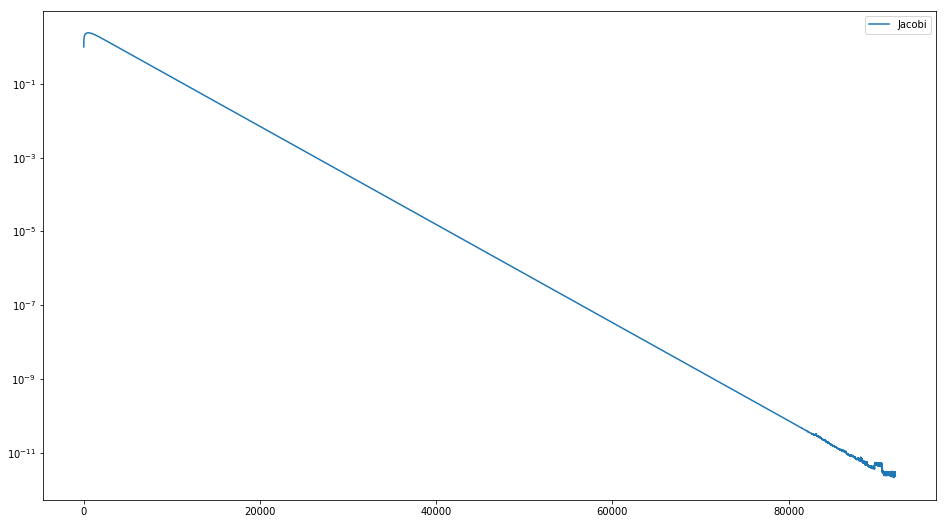

In [104]:
do_jacobi()

Converged 110692
Done


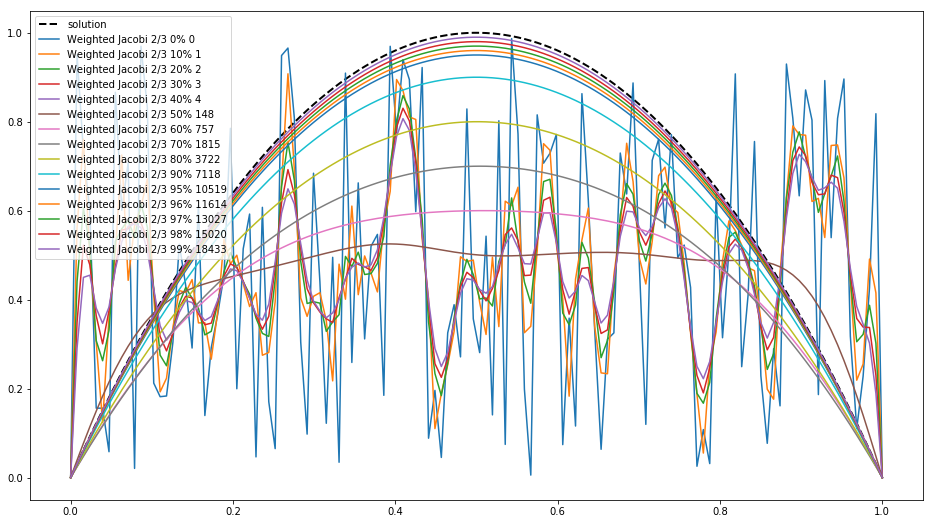

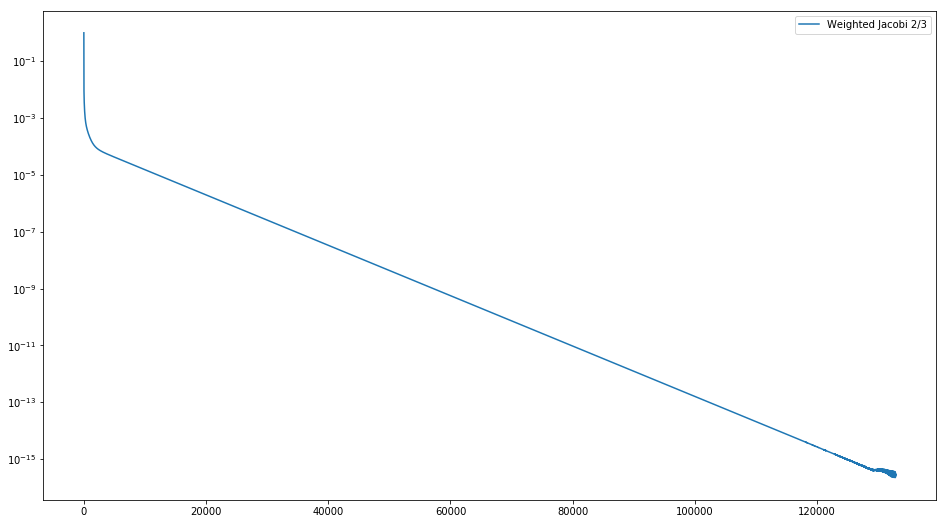

In [19]:
do_weighted_jacobi()

Converged 40426
Done


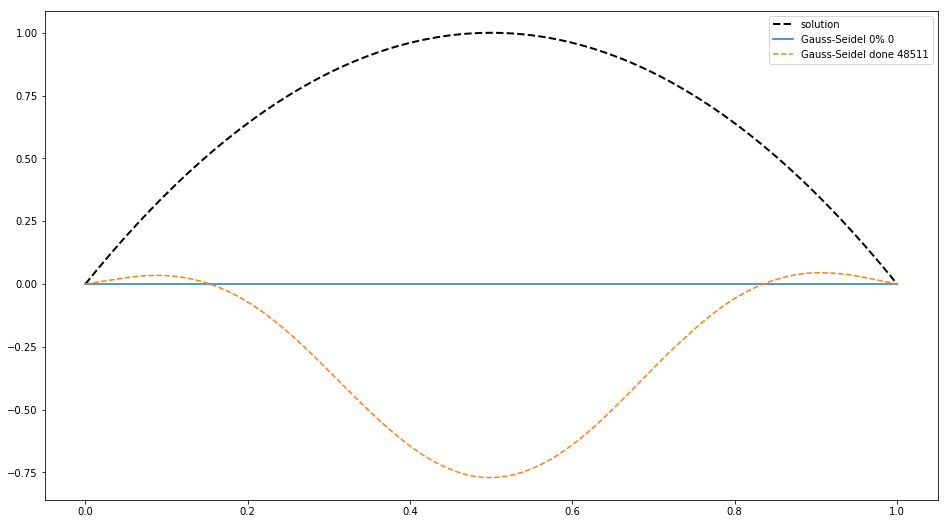

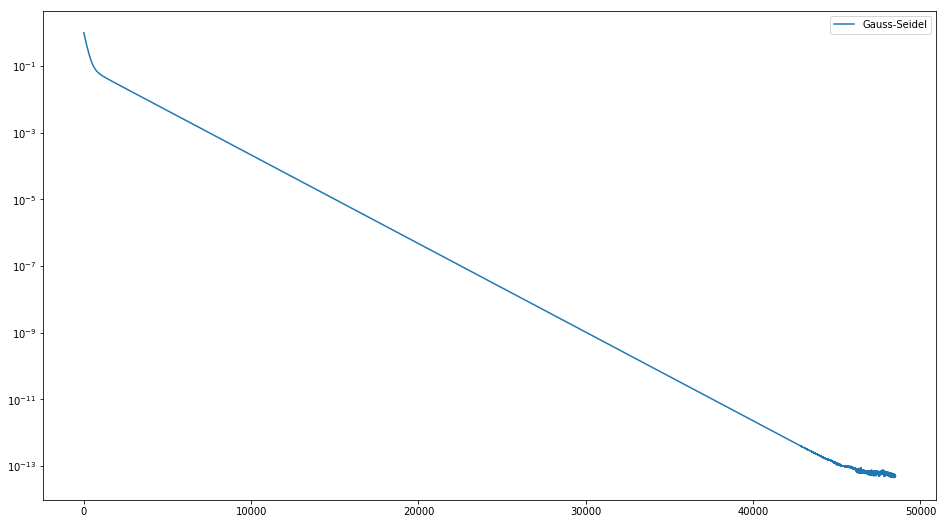

In [92]:
do_gauss_seidel()

Converged 36803
Done


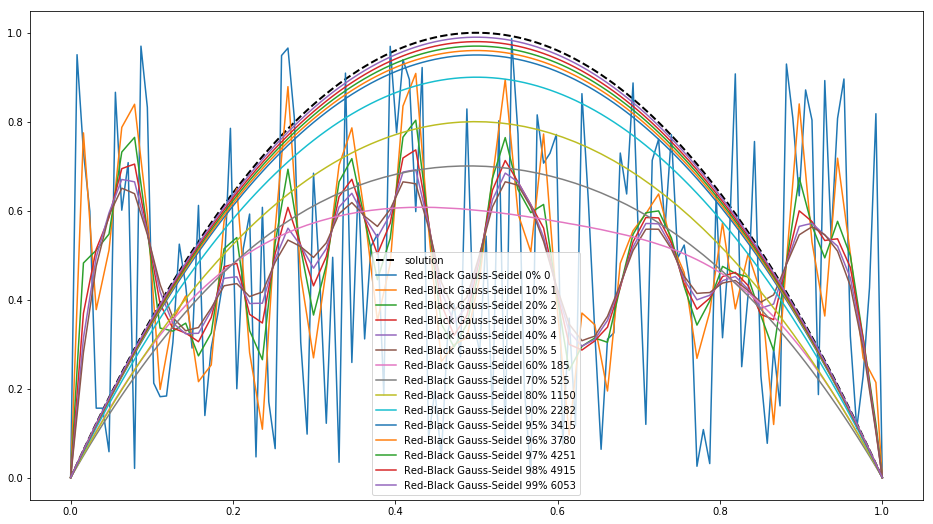

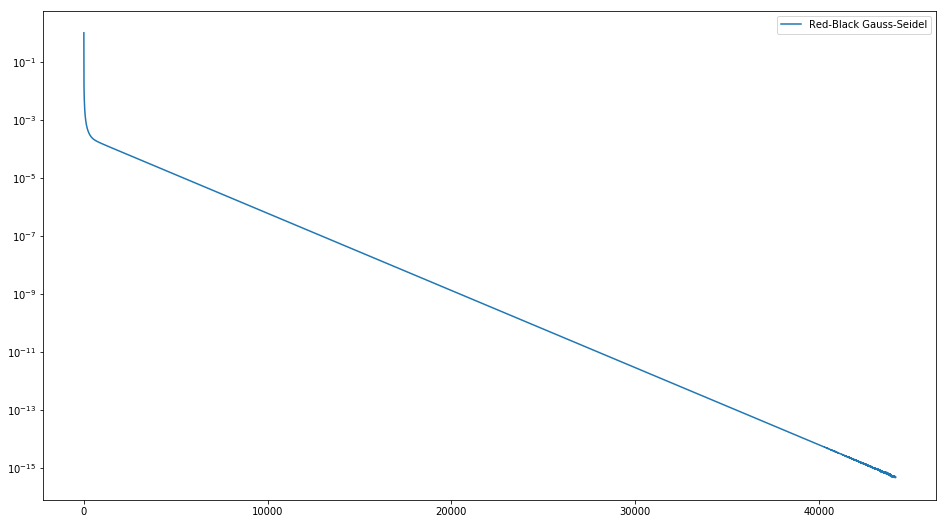

In [21]:
do_red_black_gauss_seidel()

Converged 13320
Done


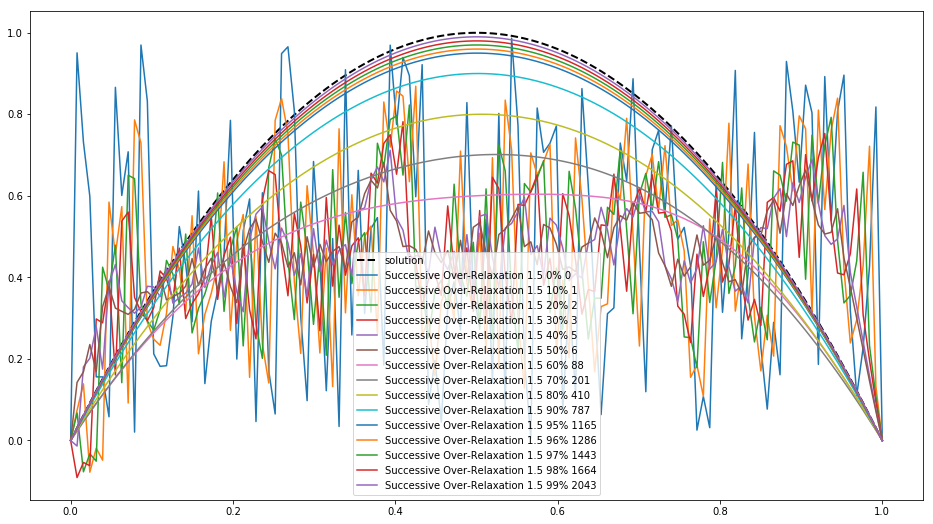

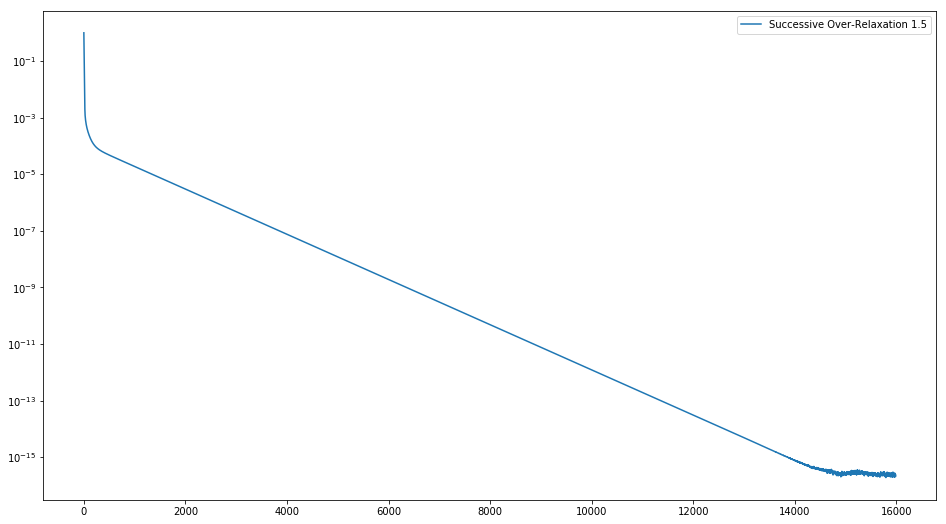

In [22]:
do_successive_over_relaxation(1.5)

Converged 4501
Done


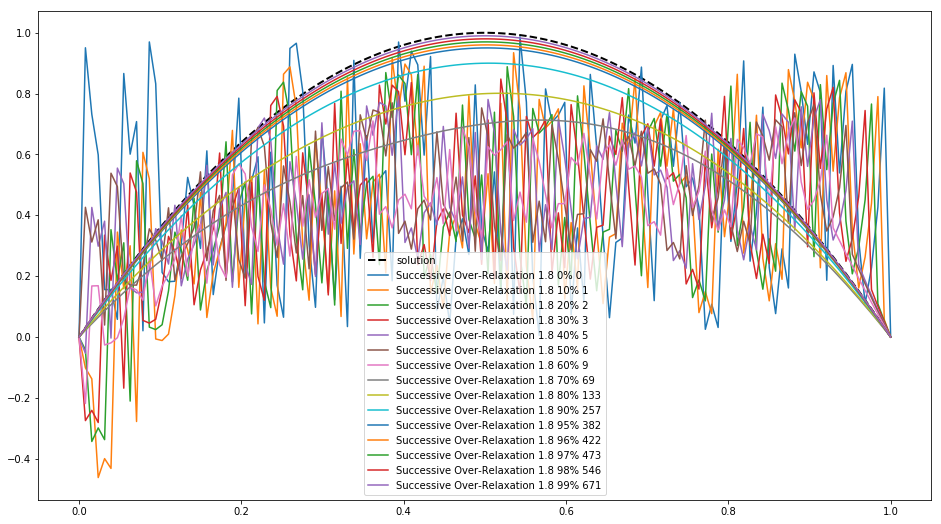

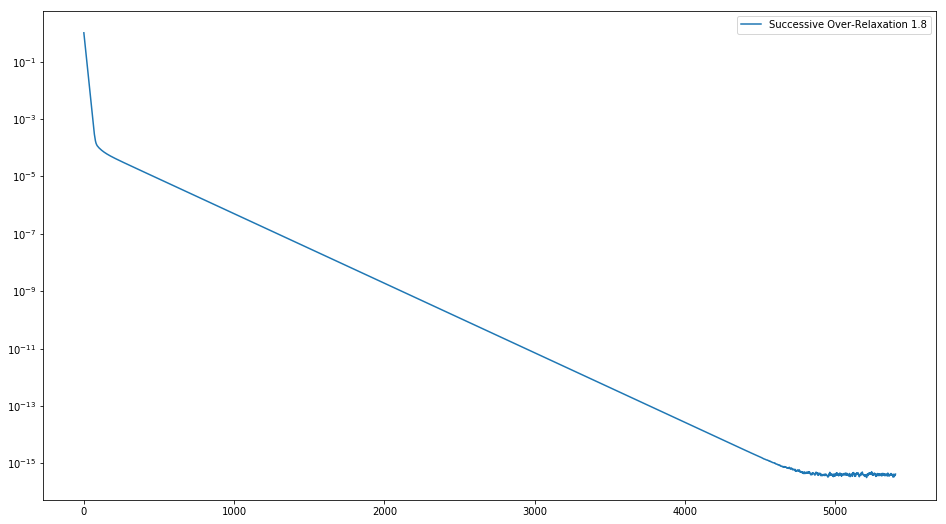

In [23]:
do_successive_over_relaxation(1.8)

Converged 2085
Done


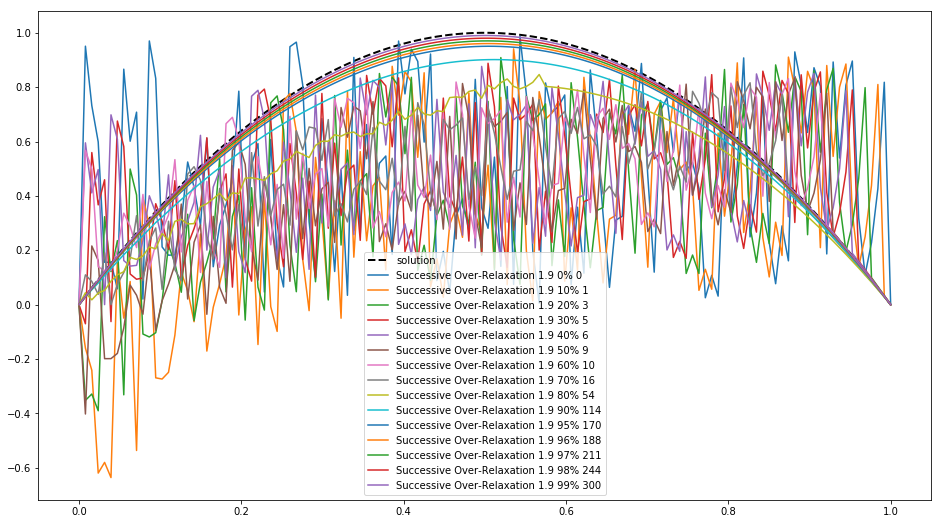

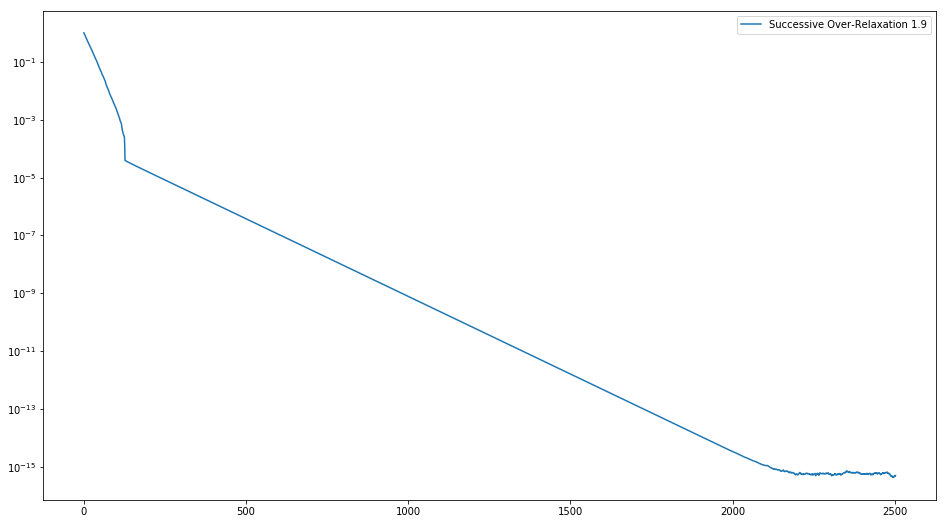

In [24]:
do_successive_over_relaxation(1.9)

Converged 13527
Done


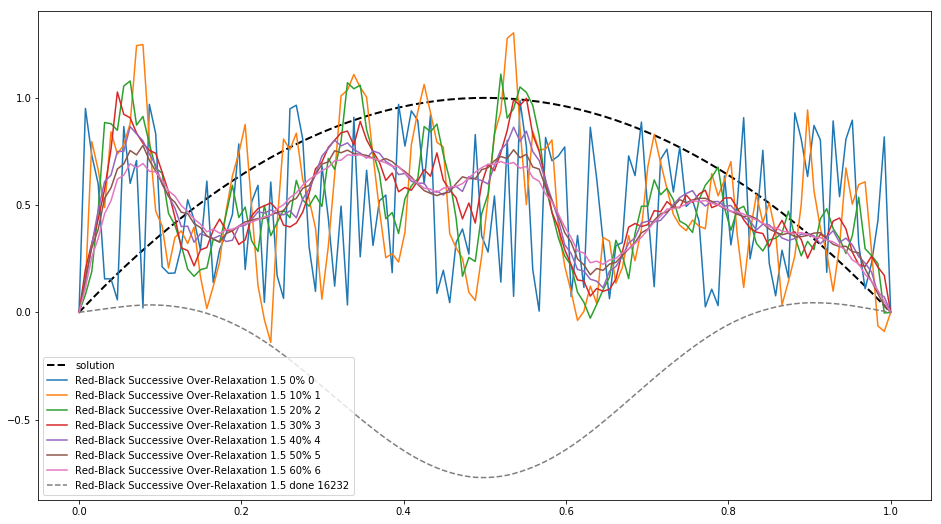

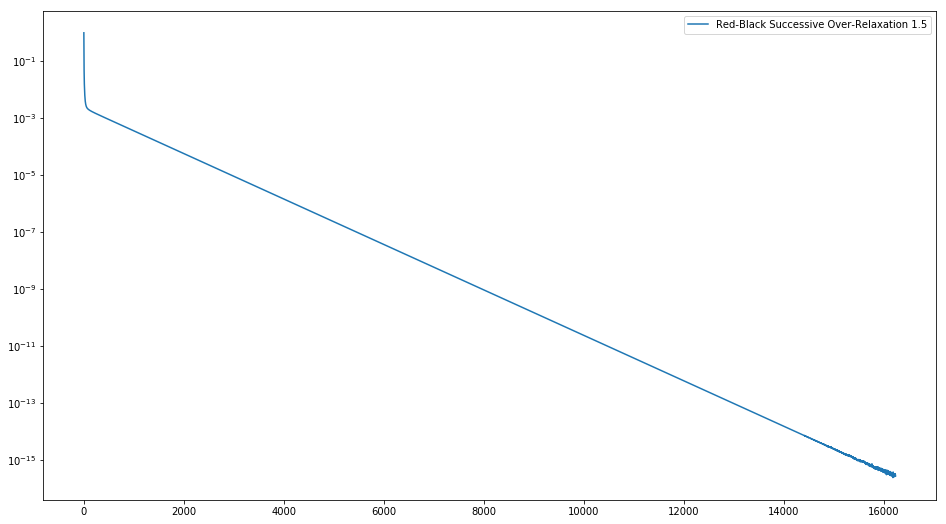

In [85]:
do_red_black_successive_over_relaxation(1.5)

Converged 4825
Done


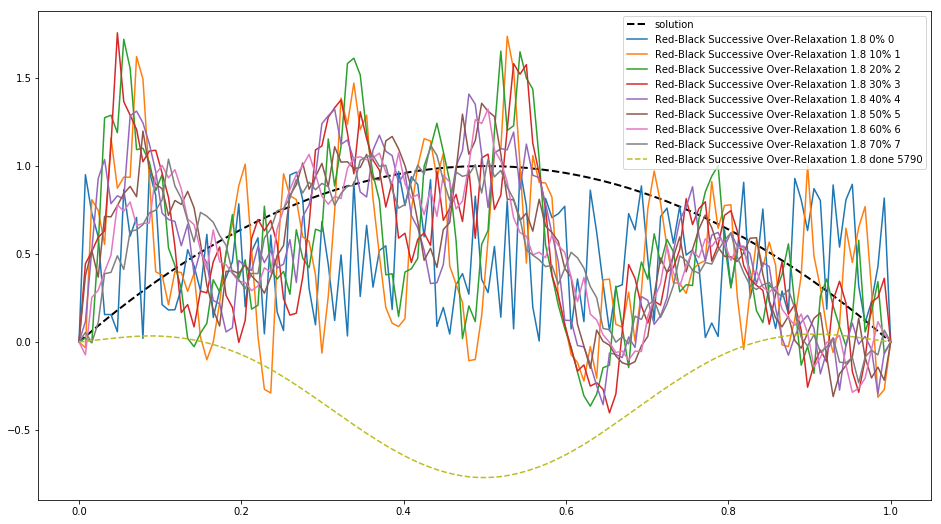

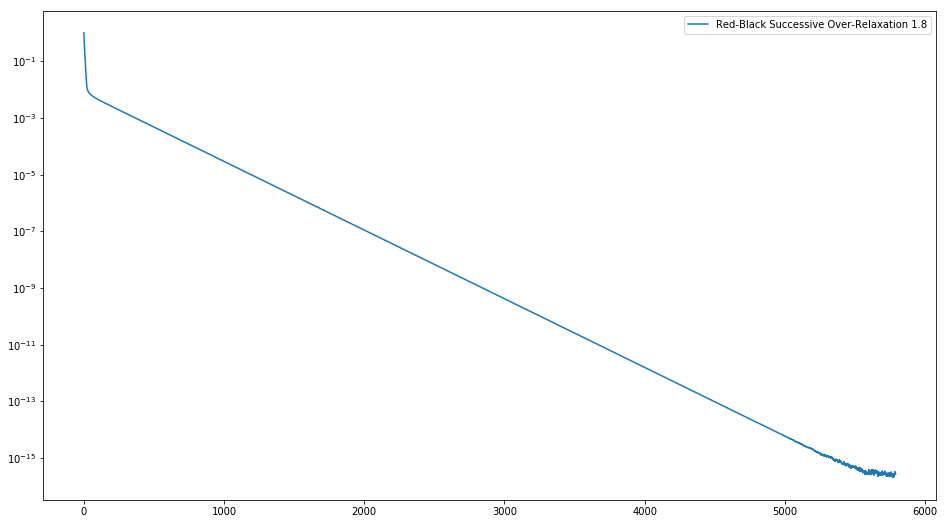

In [81]:
do_red_black_successive_over_relaxation(1.8)

Converged 2217
Done


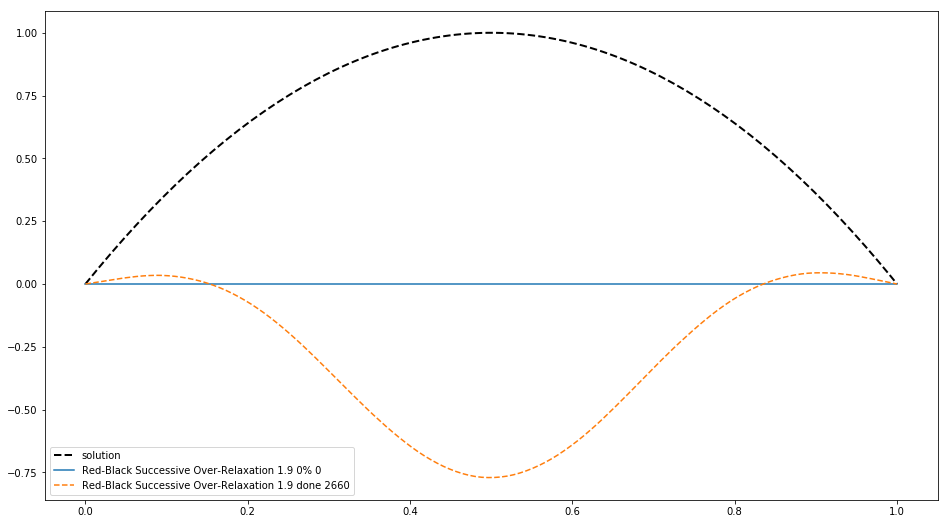

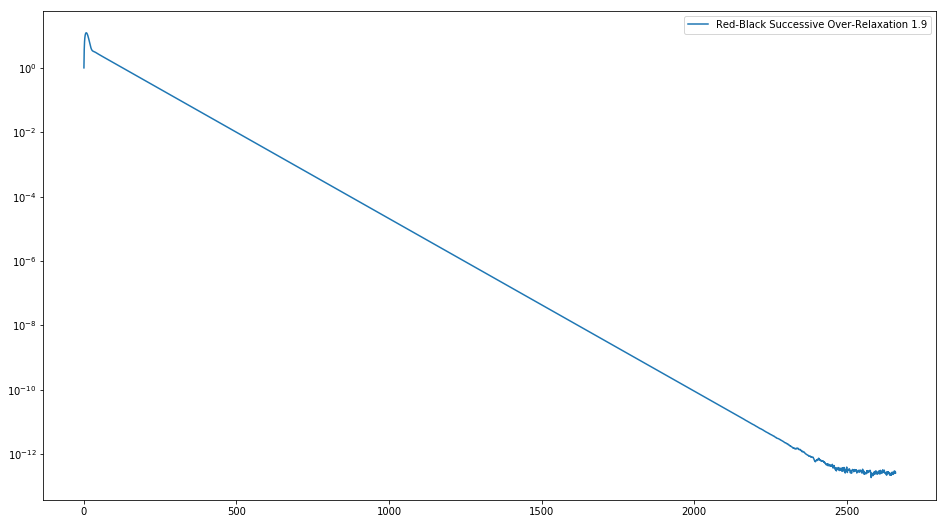

In [91]:
do_red_black_successive_over_relaxation(1.9)

Converged 130


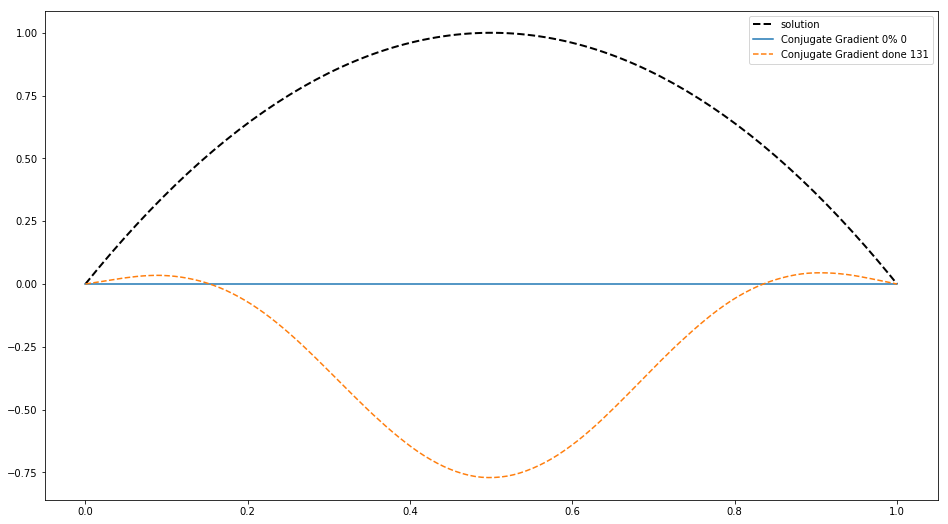

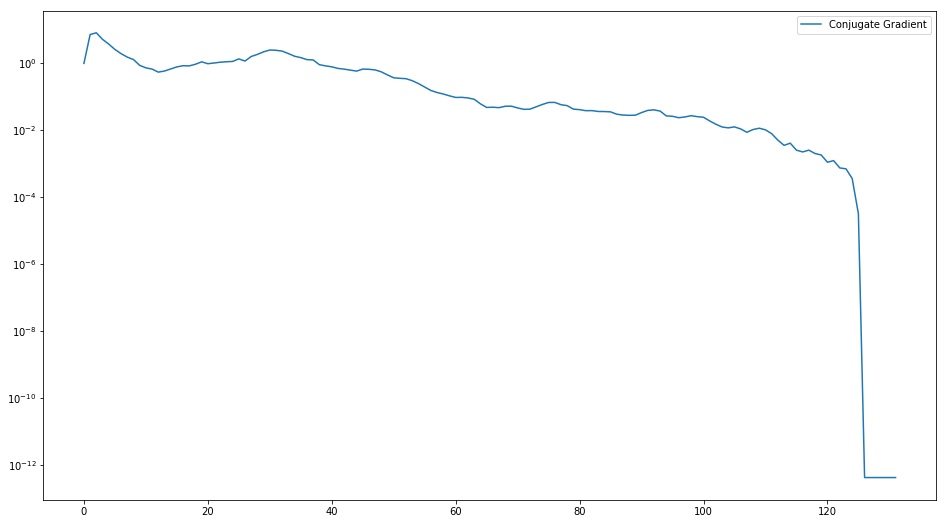

In [90]:
do_conjugate_gradient()

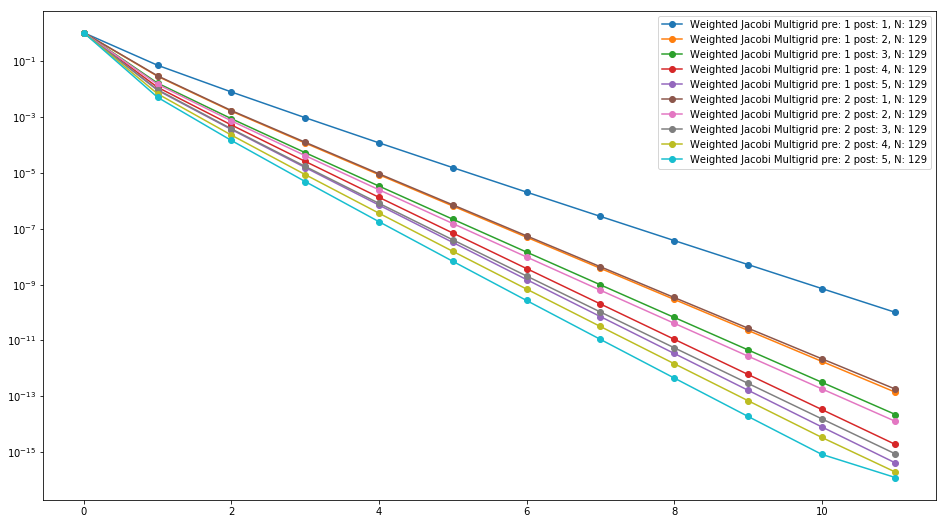

In [84]:
do_weighted_jacobi_multigrid(0)

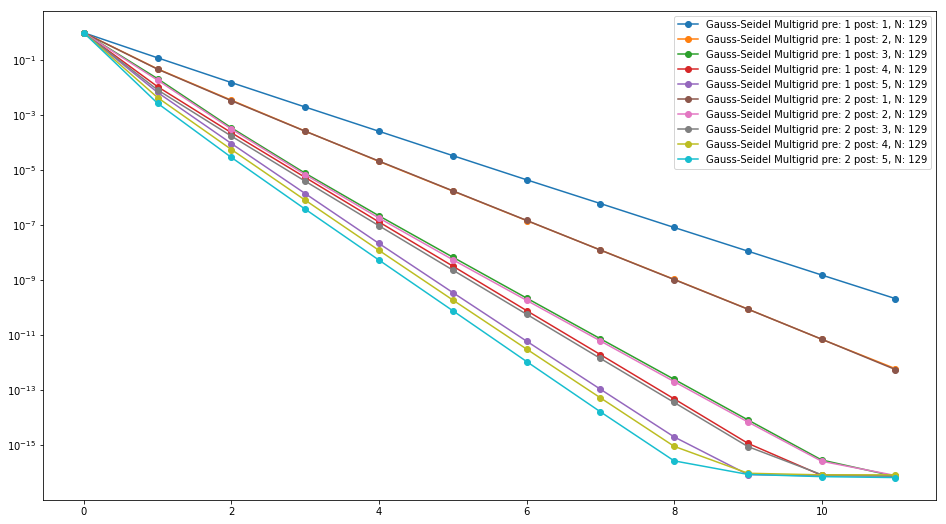

In [83]:
do_weighted_jacobi_multigrid(1)

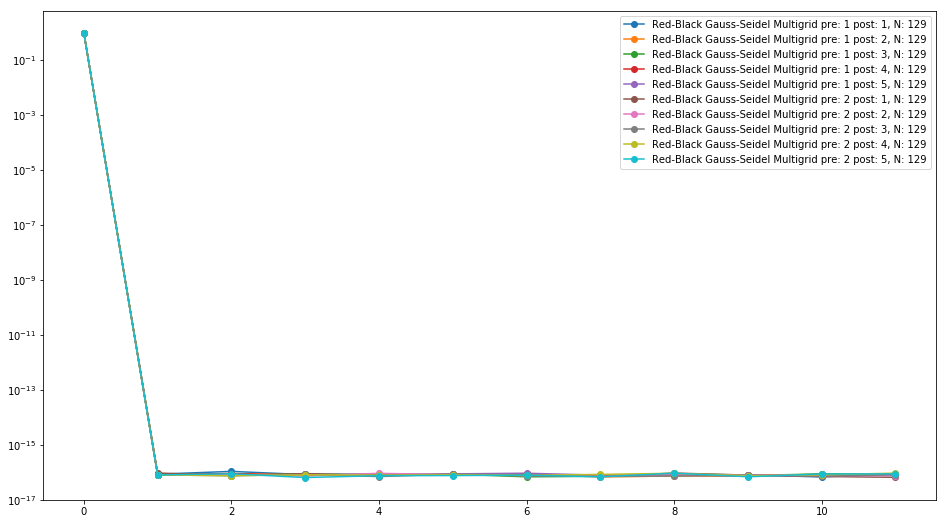

In [82]:
do_weighted_jacobi_multigrid(2)